In [43]:
import polars as pl
import sqlite3
from pathlib import Path
import os

In [48]:
def read_telemetry(filename: str | Path) -> pl.DataFrame:
    """
    Read GT7 telemetry NDJSON file into a Polars DataFrame.
    Expands array fields into separate columns.
    """
    # Read the base dataframe
    df = pl.read_ndjson(filename)
    
    # Print schema to debug
    print("Original schema:")
    print(df.schema)
    
    # Try a different approach to expand arrays
    df = df.with_columns([
        # Position
        pl.col("position").list.get(0).alias("position_x"),
        pl.col("position").list.get(1).alias("position_y"),
        pl.col("position").list.get(2).alias("position_z"),
        
        # Velocity
        pl.col("velocity").list.get(0).alias("velocity_x"),
        pl.col("velocity").list.get(1).alias("velocity_y"),
        pl.col("velocity").list.get(2).alias("velocity_z"),
        
        # Rotation
        pl.col("rotation").list.get(0).alias("rotation_x"),
        pl.col("rotation").list.get(1).alias("rotation_y"),
        pl.col("rotation").list.get(2).alias("rotation_z"),
        
        # Angular velocity
        pl.col("angular_velocity").list.get(0).alias("angular_velocity_x"),
        pl.col("angular_velocity").list.get(1).alias("angular_velocity_y"),
        pl.col("angular_velocity").list.get(2).alias("angular_velocity_z"),
        
        # Road plane
        pl.col("road_plane").list.get(0).alias("road_plane_x"),
        pl.col("road_plane").list.get(1).alias("road_plane_y"),
        pl.col("road_plane").list.get(2).alias("road_plane_z"),
        
        # Gear ratios
        *[pl.col("gear_ratios").list.get(i).alias(f"gear_ratio_{i+1}")
          for i in range(7)],
        
        # Derived columns
        (pl.col("meters_per_second") * 3.6).alias("speed_kmh"),
        (pl.col("packet_id") / 60.0).alias("time_seconds"),
    ])
    
    # Drop original array columns
    df = df.drop(["position", "velocity", "rotation", "angular_velocity", 
                  "road_plane", "gear_ratios"])
    
    return df

def get_basic_stats(df: pl.DataFrame) -> pl.DataFrame:
    """Get basic statistics about the telemetry data."""
    return df.select([
        pl.len().alias("total_packets"),
        pl.col("speed_kmh").mean().alias("avg_speed_kmh"),
        pl.col("speed_kmh").max().alias("max_speed_kmh"),
        pl.col("engine_rpm").mean().alias("avg_rpm"),
        pl.col("engine_rpm").max().alias("max_rpm"),
        ((pl.col("packet_id").max() - pl.col("packet_id").min()) / 60.0).alias("duration_seconds"),
    ])

In [64]:
def clean_telemetry(df: pl.DataFrame) -> pl.DataFrame:
    """
    Clean telemetry data by:
    1. Sorting by packet_id
    2. Calculating time_of_day_progression delta
    3. Filtering for normal 60Hz updates (16-17ms deltas)
    """
    return (df
        .sort("packet_id")
        .with_columns([
            (pl.col("time_of_day_progression") - 
             pl.col("time_of_day_progression").shift(1))
            .alias("time_delta")
        ])
        .filter(pl.col("time_delta").is_between(10, 20))
    )

In [70]:
import plotly.express as px
import plotly.graph_objects as go
import polars as pl

def plot_track(df: pl.DataFrame, color_by: str = 'speed_kmh') -> go.Figure:
    """
    Plot the racing line on the track.
    
    Args:
        df: Telemetry dataframe
        color_by: Column to use for color coding (e.g., 'speed_kmh', 'current_gear', 'throttle')
    """
    # Convert to pandas for plotly
    pdf = df.select(['position_x', 'position_y', color_by, 'time_of_day_progression']).to_pandas()
    
    # Create the scatter plot
    fig = px.scatter(pdf, 
        x='position_x', 
        y='position_y',
        color=color_by,
        color_continuous_scale='viridis',  # or 'RdYlBu' for speed
        title=f'Track View (colored by {color_by})',
        hover_data=['time_of_day_progression'],  # show time on hover
        render_mode='svg'  # better for line visualization
    )
    
    # Update layout for better visibility
    fig.update_traces(marker=dict(size=2))
    fig.update_layout(
        plot_bgcolor='white',
        width=800,
        height=800,
        title_x=0.5,  # center title
    )
    
    return fig

In [44]:
def setup_database(db_path: str) -> sqlite3.Connection:
    """Create database and tables if they don't exist"""
    conn = sqlite3.connect(db_path)
    
    # Create runs table
    conn.execute("""
        CREATE TABLE IF NOT EXISTS runs (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            filename TEXT NOT NULL,
            created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
        )
    """)
    
    return conn

def create_telemetry_table(conn: sqlite3.Connection, df: pl.DataFrame, run_id: int):
    """Create telemetry table using DataFrame schema"""
    
    # Map Polars types to SQLite types
    type_mapping = {
        pl.Float64: "REAL",
        pl.Int64: "INTEGER",
        pl.Utf8: "TEXT",
        pl.Boolean: "INTEGER",  # SQLite doesn't have boolean
    }
    
    # Generate column definitions
    columns = []
    for name, dtype in df.schema.items():
        sql_type = type_mapping.get(type(dtype), "TEXT")
        columns.append(f"{name} {sql_type}")
    
    # Create table with all columns plus run_id
    create_sql = f"""
    CREATE TABLE IF NOT EXISTS telemetry (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        run_id INTEGER NOT NULL,
        {', '.join(columns)},
        FOREIGN KEY(run_id) REFERENCES runs(id)
    )
    """
    conn.execute(create_sql)

In [30]:
def analyze_flags(df: pl.DataFrame) -> pl.DataFrame:
    """
    Group by flags and count occurrences, 
    also show some context like avg speed for each flag state
    """
    flags_stats = df.group_by("flags").agg([
        pl.len().alias("count"),
        pl.col("speed_kmh").mean().alias("avg_speed"),
        pl.col("position_x").std().alias("position_variation"),
        # Calculate percentage of total
        (pl.len() / len(df) * 100).alias("percentage")
    ]).sort("count", descending=True)

    # Configure wider output
    with pl.Config(fmt_str_lengths=100, tbl_width_chars=1000):
        print("\nFlag distribution:")
        print(flags_stats)
    return flags_stats

In [65]:
def save_to_sqlite(df: pl.DataFrame, filename: str, db_path: str = "gt7_telemetry.db"):
    """Save telemetry data to SQLite database"""
    conn = setup_database(db_path)
    
    try:
        # Insert run record
        cur = conn.execute(
            "INSERT INTO runs (filename) VALUES (?)",
            (filename,)
        )
        run_id = cur.lastrowid
        
        # Create or update telemetry table
        df_ordered = df.sort("packet_id")

        create_telemetry_table(conn, df_ordered, run_id)
        
        # Convert DataFrame to rows for SQLite
        # Note: Polars to_dicts() is memory efficient
        rows = df_ordered.with_columns(pl.lit(run_id).alias("run_id")).to_dicts()
        
        # Prepare column names for INSERT
        columns = ["run_id"] + [name for name in df_ordered.columns]
        placeholders = ",".join("?" * len(columns))
        
        # Insert telemetry data
        insert_sql = f"INSERT INTO telemetry ({','.join(columns)}) VALUES ({placeholders})"
        
        # Convert rows to tuples for sqlite
        rows_as_tuples = [tuple(row[col] for col in columns) for row in rows]
        
        # Batch insert for better performance
        conn.executemany(insert_sql, rows_as_tuples)
        
        conn.commit()
        print(f"Saved run {run_id} with {len(df_ordered)} telemetry records")
        
    finally:
        conn.close()

In [66]:
df = read_telemetry("recordings/telemetry-IA-9-deep-forest-my-record.ndjson")
df = clean_telemetry(df)
save_to_sqlite(df, "telemetry-IA-9-deep-forest-my-record", "gt7-telemetry.db")

Original schema:
Schema({'tire_rr_surface_temperature': Float64, 'alert_rpm_max': Int64, 'tire_fr_radius': Float64, 'oil_temperature': Float64, 'lap_count': Int64, 'tire_fl_surface_temperature': Float64, 'alert_rpm_min': Int64, 'rotation': List(Float64), 'body_height': Float64, 'wheel_rr_rps': Float64, 'tire_rl_radius': Float64, 'engine_rpm': Float64, 'packet_id': Int64, 'meters_per_second': Float64, 'tire_fl_suspension_height': Float64, 'clutch_engagement': Float64, 'relative_orientation_to_north': Float64, 'last_lap_time': Int64, 'suggested_gear': Int64, 'best_lap_time': Int64, 'tire_fl_radius': Float64, 'time_of_day_progression': Int64, 'tire_rr_radius': Float64, 'tire_fr_suspension_height': Float64, 'clutch_pedal': Float64, 'gas_level': Float64, 'transmission_top_speed': Float64, 'flags': String, 'gear_ratios': List(Float64), 'calculated_max_speed': Int64, 'tire_rl_surface_temperature': Float64, 'velocity': List(Float64), 'wheel_fl_rps': Float64, 'current_gear': Int64, 'position': 

In [50]:
df.to_pandas()

,tire_rr_surface_temperature,alert_rpm_max,tire_fr_radius,oil_temperature,lap_count,tire_fl_surface_temperature,alert_rpm_min,body_height,wheel_rr_rps,tire_rl_radius,...,road_plane_z,gear_ratio_1,gear_ratio_2,gear_ratio_3,gear_ratio_4,gear_ratio_5,gear_ratio_6,gear_ratio_7,speed_kmh,time_seconds
0,46.321712,8000,0.325,110.0,0,46.531030,7500,0.053805,-0.0,0.325,...,-0.001216,2.754,1.928,1.42,1.106,0.886,0.74,0.0,0.0,8844.033333
1,46.320900,8000,0.325,110.0,0,46.530220,7500,0.053804,-0.0,0.325,...,-0.001216,2.754,1.928,1.42,1.106,0.886,0.74,0.0,0.0,8844.050000
2,46.320087,8000,0.325,110.0,0,46.529410,7500,0.053804,-0.0,0.325,...,-0.001216,2.754,1.928,1.42,1.106,0.886,0.74,0.0,0.0,8844.066667
3,46.319275,8000,0.325,110.0,0,46.528603,7500,0.053804,-0.0,0.325,...,-0.001216,2.754,1.928,1.42,1.106,0.886,0.74,0.0,0.0,8844.083333
4,46.318462,8000,0.325,110.0,0,46.527794,7500,0.053804,-0.0,0.325,...,-0.001216,2.754,1.928,1.42,1.106,0.886,0.74,0.0,0.0,8844.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3651,69.657295,8000,0.325,110.0,0,69.659424,7500,0.053804,-0.0,0.325,...,-0.001217,2.754,1.928,1.42,1.106,0.886,0.74,0.0,0.0,8904.950000
3652,69.656044,8000,0.325,110.0,0,69.658180,7500,0.053804,-0.0,0.325,...,-0.001216,2.754,1.928,1.42,1.106,0.886,0.74,0.0,0.0,8904.966667
3653,69.654790,8000,0.325,110.0,0,69.656940,7500,0.053804,-0.0,0.325,...,-0.001217,2.754,1.928,1.42,1.106,0.886,0.74,0.0,0.0,8904.983333
3654,69.653540,8000,0.325,110.0,0,69.655690,7500,0.053805,-0.0,0.325,...,-0.001216,2.754,1.928,1.42,1.106,0.886,0.74,0.0,0.0,8905.000000


In [67]:
df_2 = read_telemetry("recordings/telemetry-IA-9-deep-forest-with-controller.ndjson")
df_2 = clean_telemetry(df)
save_to_sqlite(df_2, "telemetry-IA-9-deep-forest-with-controller", "gt7-telemetry.db")

Original schema:
Schema({'tire_rr_surface_temperature': Float64, 'alert_rpm_max': Int64, 'tire_fr_radius': Float64, 'oil_temperature': Float64, 'lap_count': Int64, 'tire_fl_surface_temperature': Float64, 'alert_rpm_min': Int64, 'rotation': List(Float64), 'body_height': Float64, 'wheel_rr_rps': Float64, 'tire_rl_radius': Float64, 'engine_rpm': Float64, 'packet_id': Int64, 'meters_per_second': Float64, 'tire_fl_suspension_height': Float64, 'clutch_engagement': Float64, 'relative_orientation_to_north': Float64, 'last_lap_time': Int64, 'suggested_gear': Int64, 'best_lap_time': Int64, 'tire_fl_radius': Float64, 'time_of_day_progression': Int64, 'tire_rr_radius': Float64, 'tire_fr_suspension_height': Float64, 'clutch_pedal': Float64, 'gas_level': Float64, 'transmission_top_speed': Float64, 'flags': String, 'gear_ratios': List(Float64), 'calculated_max_speed': Int64, 'tire_rl_surface_temperature': Float64, 'velocity': List(Float64), 'wheel_fl_rps': Float64, 'current_gear': Int64, 'position': 

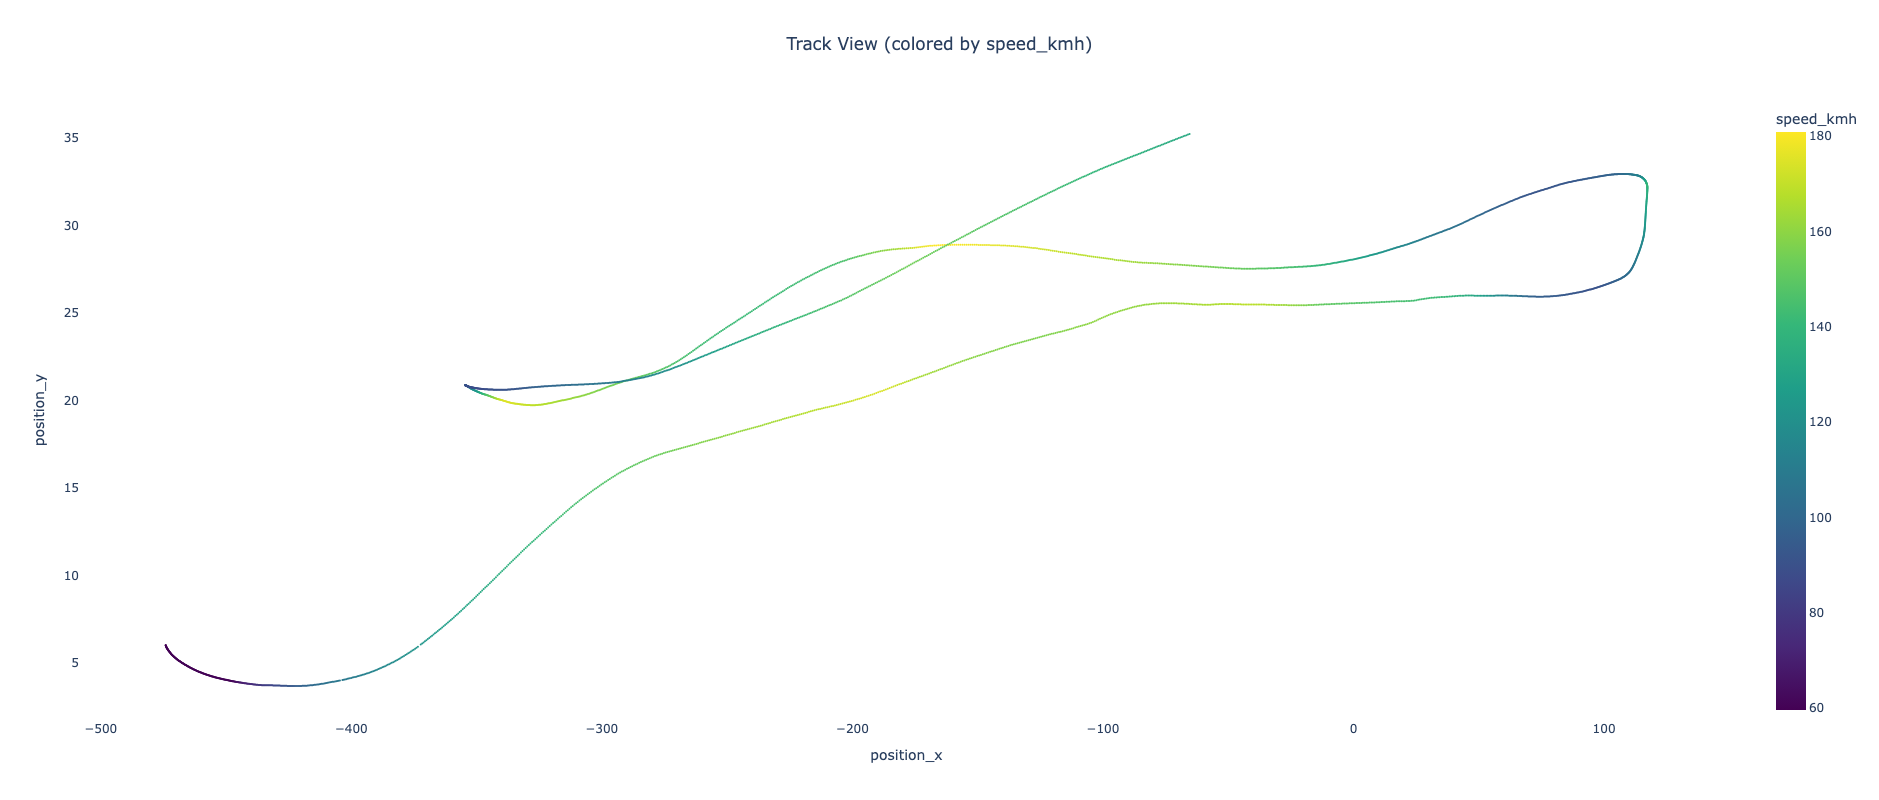

In [74]:
plot_track(df)

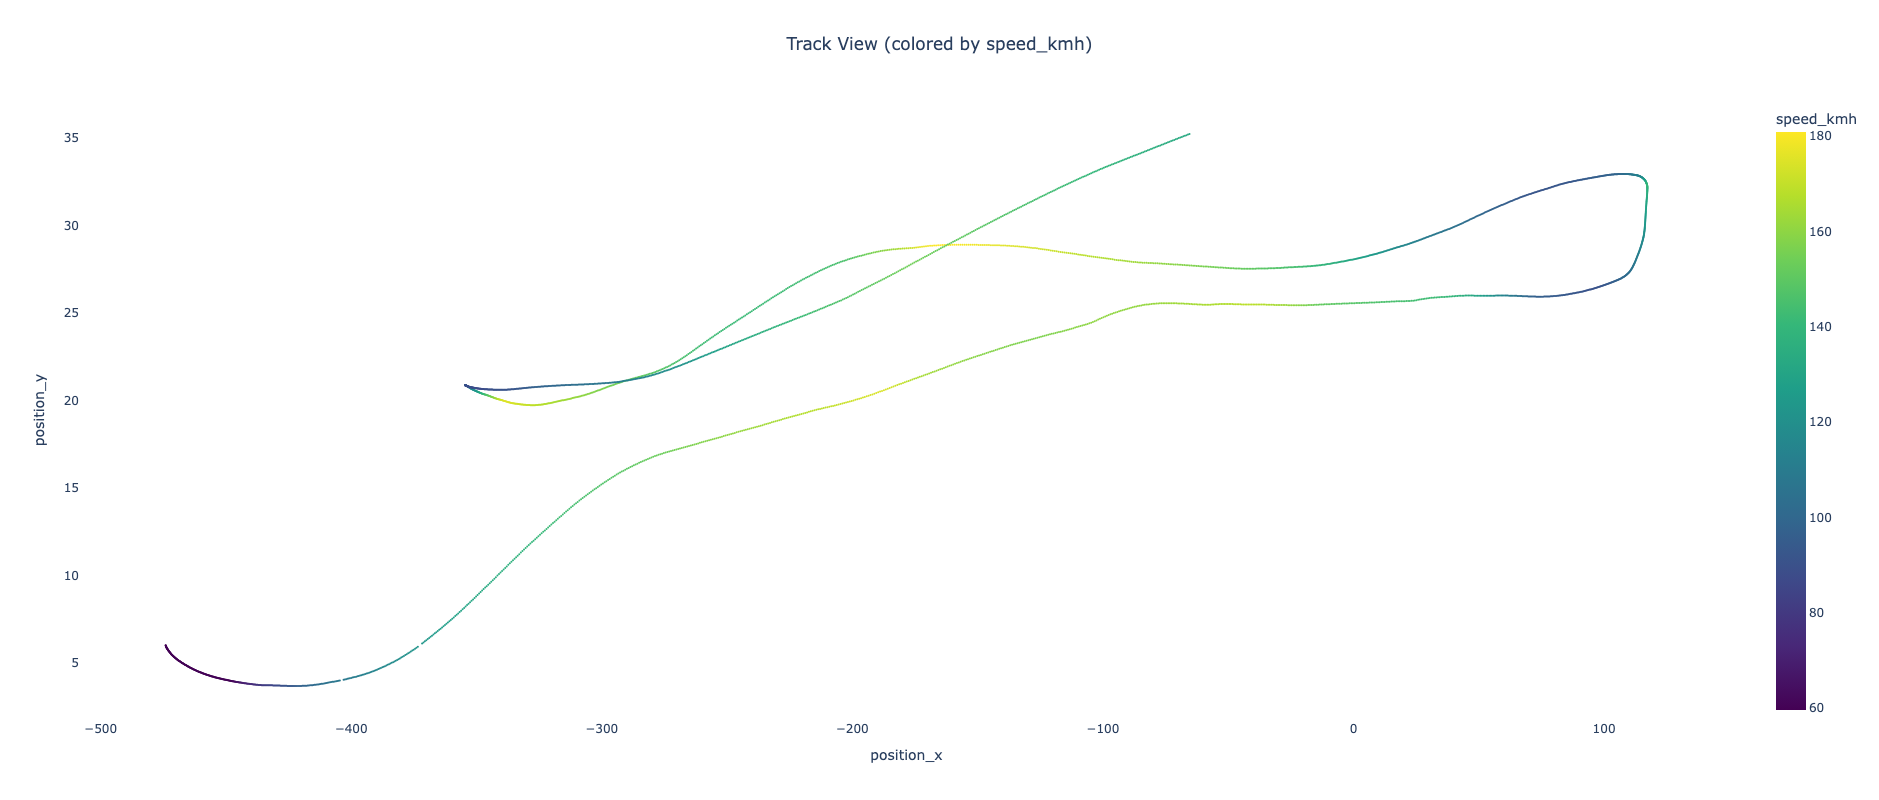

In [75]:
plot_track(df_2)